# 00 - Baseline land drops
This notebook builds the **baseline reference** for early-game mana reliability in a 60-card deck, split by **on the play vs on the draw**, using a **pure hypergeometric model** (no mulligans, no selection, no cantrips/fetches/surveil/ramp). The goal is to anchor the project with an interpretable “ground truth” curve for hitting key land drops—specifically **P(≥2 lands by Turn 2)** and **P(≥3 lands by Turn 3)**—as a function of total land count. We sweep land counts across a realistic competitive range, generate a tidy results table, and visualise the curves with clear thresholds (e.g., 80%) so later notebooks can quantify how mulligans, top manipulation, taplands, and player behaviour shift outcomes relative to this baseline.


## Libraries

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import seaborn as sns
from scipy.stats import hypergeom
import sys
from pathlib import Path

project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
project_root

from src.mtg_mana.config import FIGURES_DIR, PROCESSED_DATA_DIR


## Parameters

In [4]:
def params(decksize = 60, 
           min_lands = 16, 
           max_lands = 29,
           land_count = None,
           mulligan = 0,
           dieroll = 'Play'):
    
    """
    Return bookkeeping parameters for early turns (T1–T3) for a 60-card baseline model.

    Computes cards-in-hand and cards-seen counts for turns 1–3 given:
    - deck size
    - land-count sweep range
    - play vs draw (draw gets an extra card on T1)
    - a fixed mulligan count interpreted as final hand size = 7 - mulligan

    Notes:
    - This does not simulate London mulligan decisions (shuffle/redraw/bottoming); it only
      provides turn-by-turn counts conditional on a chosen mulligan count.
    """
    
    if mulligan >3 or mulligan < 0:
        raise ValueError('❌ No more than 3 (or less than 0) mulligans allowed.')
    
    dieroll_options = ['play', 'draw']

    if dieroll.strip().lower() not in dieroll_options:
        raise ValueError('❌ Dieroll argument takes only "Play" or "Draw".')
    
    N = decksize

    if land_count is None:
        land_count = range(min_lands, max_lands+1)
    else:
        land_count = land_count


    starting_hand = 7 - mulligan

    if dieroll.strip().lower() == 'draw':
        cards_hand_t1 = starting_hand + 1
        cards_seen_t1 = 8
    else:
        cards_hand_t1 = starting_hand
        cards_seen_t1 = 7
    
    cards_hand_t2 = cards_hand_t1 + 1
    cards_hand_t3 = cards_hand_t2 + 1
    cards_hand_t4 = cards_hand_t3 + 1

    cards_seen_t2 = cards_seen_t1 + 1
    cards_seen_t3 = cards_seen_t2 + 1
    cards_seen_t4 = cards_seen_t3 + 1
    
    

    parameters = {
        'decksize': N,
        'dieroll':dieroll,
        'land_count':land_count,
        'cards_hand_t1':cards_hand_t1,
        'cards_hand_t2':cards_hand_t2,
        'cards_hand_t3':cards_hand_t3,
        'cards_hand_t4':cards_hand_t4,
        'cards_seen_t1':cards_seen_t1,
        'cards_seen_t2':cards_seen_t2,
        'cards_seen_t3':cards_seen_t3,
        'cards_seen_t4':cards_seen_t4
    }

    return parameters

In [5]:
p = params()
p

{'decksize': 60,
 'dieroll': 'Play',
 'land_count': range(16, 30),
 'cards_hand_t1': 7,
 'cards_hand_t2': 8,
 'cards_hand_t3': 9,
 'cards_hand_t4': 10,
 'cards_seen_t1': 7,
 'cards_seen_t2': 8,
 'cards_seen_t3': 9,
 'cards_seen_t4': 10}

## Baseline probabilities - Hypergeometrics 

In [6]:
p_play = params(land_count= 24, dieroll='play')
p_draw = params(land_count= 24, dieroll='draw')

In [ ]:
def land_prob(decksize = 60,
              land_count = 24,
              cards_seen = 8,
              lands_seen = 2) -> float:
    """
    Probability of seeing at least `lands_seen` lands in `cards_seen` cards from a deck.

    Models X ~ Hypergeometric(N=decksize, K=land_count, n=cards_seen) and returns P(X >= lands_seen).

    Notes:
    - This is a baseline probability utility (no mulligan process, no cantrips, no fetch/surveil/ramp).
    - Practical constraints are enforced for this project context (60-card competitive baseline).

    Parameters
    ----------
    decksize : int
        Total cards in deck (default 60).
    land_count : int
        Number of lands in deck.
    cards_seen : int
        Number of cards seen by a given point (e.g., by turn T).
    lands_seen : int
        Minimum number of lands desired among the seen cards.

    Returns
    -------
    float
        P(X >= lands_seen)
    """

    # Keep "practical" land-count bounds light; realism mostly comes from your sweep range.
    # This cap prevents absurd inputs while not over-constraining future work.
    if not (10 <= land_count <= decksize - 20):
        raise ValueError("⛔️ land_count must be between 10 and decksize-20 (inclusive) for this baseline.")

    # Cards seen: in this project we won't call this below 7, but allow 7 explicitly.
    if not (7 <= cards_seen <= decksize):
        raise ValueError("⛔️ cards_seen must be between 7 and decksize (inclusive).")

    # lands_seen is bounded by what you could possibly see
    if not (0 <= lands_seen <= cards_seen):
        raise ValueError("⛔️ lands_seen must be between 0 and cards_seen (inclusive).")

    prob = 1.0 - hypergeom.cdf(lands_seen - 1, decksize, land_count, cards_seen)
    
    return float(prob)
    

In [8]:
p_play

{'decksize': 60,
 'dieroll': 'play',
 'land_count': 24,
 'cards_hand_t1': 7,
 'cards_hand_t2': 8,
 'cards_hand_t3': 9,
 'cards_hand_t4': 10,
 'cards_seen_t1': 7,
 'cards_seen_t2': 8,
 'cards_seen_t3': 9,
 'cards_seen_t4': 10}

## Compute range of probabilities across land range

In [9]:
out = []
for land in p['land_count']:
    for t in (2,3,4):
        # Play
        p = land_prob(decksize=p_play['decksize'], 
                        land_count=land, 
                        cards_seen=p_play[f'cards_seen_t{t}'],
                        lands_seen=t)
        
        res = {'lands':land,
                'dieroll':'Play',
                'turn':t,
                'land_target':t,
                'p': p}
        
        out.append(res)

        # Draw
        d = land_prob(decksize=p_draw['decksize'], 
                        land_count=land, 
                        cards_seen=p_draw[f'cards_seen_t{t}'],
                        lands_seen=t)
        
        res = {'lands':land,
            'dieroll':'Draw',
            'turn':t,
            'land_target':t,
            'p': d}
        
        out.append(res)

hyper_res = pd.DataFrame(out)

In [10]:
hyper_res

,lands,dieroll,turn,land_target,p
0,16,Play,2,2,0.691099
1,16,Draw,2,2,0.760223
2,16,Play,3,3,0.449162
3,16,Draw,3,3,0.534551
4,16,Play,4,4,0.249920
...,...,...,...,...,...
79,29,Draw,2,2,0.983161
80,29,Play,3,3,0.910943
81,29,Draw,3,3,0.949176
82,29,Play,4,4,0.821733


In [11]:
hyper_res["metric"] = (
    "T" + hyper_res["turn"].astype(int).astype(str)
    + ": " + hyper_res["land_target"].astype(int).astype(str)
    + "+ lands"
)
thr = 0.80

tmp = (hyper_res
       .sort_values(["dieroll", "metric", "lands"])
       .loc[lambda df: df["p"].ge(thr)]
       .drop_duplicates(subset=["dieroll", "metric"], keep="first")
      )

table = tmp.pivot(index="metric", columns="dieroll", values="lands").sort_index()
print(table)


dieroll       Draw  Play
metric                  
T2: 2+ lands    18    20
T3: 3+ lands    23    25
T4: 4+ lands    26    29


## Save outputs

In [12]:
hyper_res.to_csv(PROCESSED_DATA_DIR / "baseline_land_drop_probs.csv", index=False)

## Figure

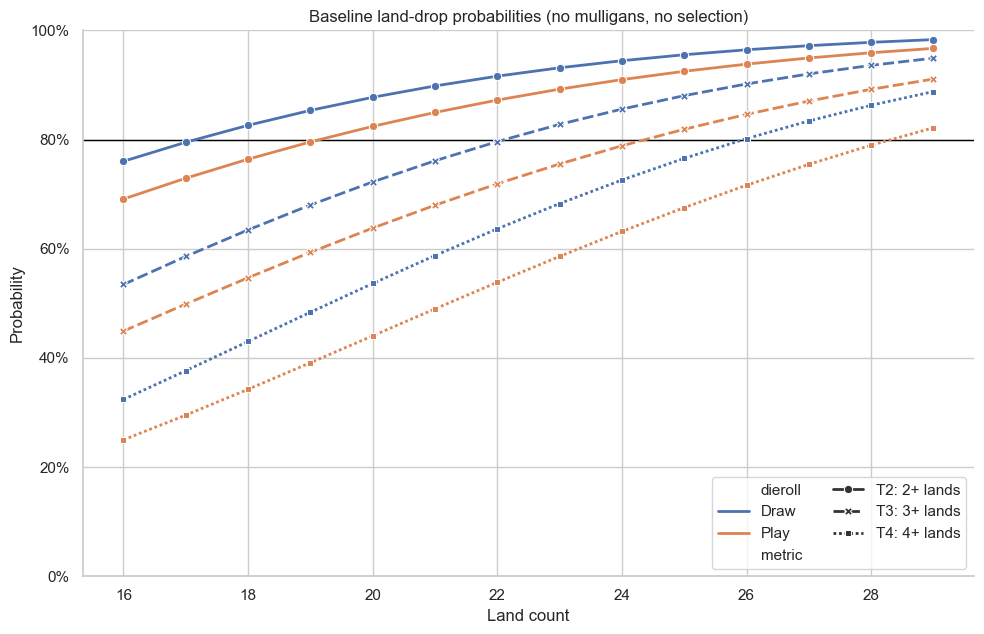

In [13]:
plot_df = hyper_res.copy()
plot_df["metric"] = plot_df.apply(
    lambda r: f"T{int(r['turn'])}: {int(r['land_target'])}+ lands",
    axis=1
)


sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 6.5))

ax.axhline(0.80, linewidth=1, color = 'black')

sns.lineplot(
    data=plot_df.sort_values(["metric", "dieroll", "lands"]),
    x="lands",
    y="p",
    hue="dieroll",
    style="metric",
    markers=True,
    dashes=True,
    linewidth=2,
    ax=ax,
)

ax.set_title("Baseline land-drop probabilities (no mulligans, no selection)")
ax.set_xlabel("Land count")
ax.set_ylabel("Probability")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylim(0, 1)



ax.legend(title="", frameon=True, ncol=2, loc="lower right")
sns.despine()
plt.tight_layout()
fig.savefig(FIGURES_DIR / "baseline_land_drop_probs.png", dpi=200, bbox_inches="tight")


# == End of Notebook ==